## Results and Insights

**Disclaimer**: _The model analyzed in this notebook is not the best one given its hyperparameters. Due to time constraints, I could not retrain and persist the best one, but this model serves as a good proxy._

Among multiple instances of the model with varying hyperparameters (depth, dropout, attention, incremental encoder context updates, using `current_level`, teacher forcing ratio), the best model configuration was:
- `hidden_dim` = 128
- 2 layers deep
- 0.5 dropout
- With attention and incremental encoder context updates
- Using `current_level`

### Exploration

- **Relevant Clusters**:
  - Investigate using the encoder embedding space.
- **Attention Scores**:
  - Analyze the attention scores across different prediction steps.

### Next Steps

- Investigate what makes the model certain vs. uncertain and evaluate the relevance of the certainty score.
- Dive deeper into attention mechanisms.

### Conclusions

- **Embedding Space**:
  - Highlighted interesting clusters indicating learned information.
- **Hyperparameter Tuning**:
  - Room for further tuning (e.g., dropout, layer width, and depth).
- **Attention Mechanism**:
  - Helpful in some cases but could be optimized further.


Use python3.11 with plotly and nbformat>=4.2.0 installed 



In [1]:
import os 
import sys
import pandas as pd 
import numpy as np
parent_dir = os.path.abspath(os.path.dirname(os.getcwd()))
sys.path.insert(0, parent_dir)
from predict.utils import *
from predict.predict import predict_with_uncertainty , plot_prediction ,  predict_plot_attention
from sklearn.manifold import TSNE
import plotly.express as px

MODEL_PATH = '../models/model_dim_128_att_True_tfr_0_layers_2.pt'  
device = torch.device("cpu")
encoder ,decoder , model = load_model(path=MODEL_PATH)


MODEL :
----------
 Seq2Seq(
  (encoder): Encoder(
    (gru): GRU(3, 128, num_layers=2, batch_first=True, dropout=0.5)
    (scalar_fc): Linear(in_features=1, out_features=128, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (gru): GRU(131, 128, num_layers=2, batch_first=True, dropout=0.5)
    (fc): Linear(in_features=128, out_features=1, bias=True)
    (attention): Attention(
      (attn): Linear(in_features=256, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=False)
    )
    (relu): ReLU()
    (dropout): Dropout(p=0.5, inplace=False)
  )
) 
----------


In [2]:
df= pd.read_json('../datasets/TRAIN_TEST_DATASET.json')

## random samples predictions

In [3]:
def plot_sample_predictions():
    sample = df.sample()
    input_seq, input_scalar, target_weeks, output_seq = torch.tensor(sample[INPUT_SEQUENCE].values[0]),torch.tensor(sample[NORM_STATICOL].values[0]),torch.tensor(sample[TARGET_WEEKS].values[0]),torch.tensor(sample[OUTPUT_SEQUENCE].values[0])
    input_seq, input_scalar, target_weeks, output_seq=input_seq.float().reshape(1,4,3), input_scalar.float().reshape(1,1), target_weeks.float().reshape(1,-1,2), output_seq.float().reshape(1,-1)
    input_seq[:, :, 0] = min_max_normalize(input_seq[:, :, 0])
    output_seq = min_max_normalize(output_seq)
    pred_json = predict_with_uncertainty(model,input_seq, input_scalar, target_weeks, output_seq)
    plot_prediction(pred_json)

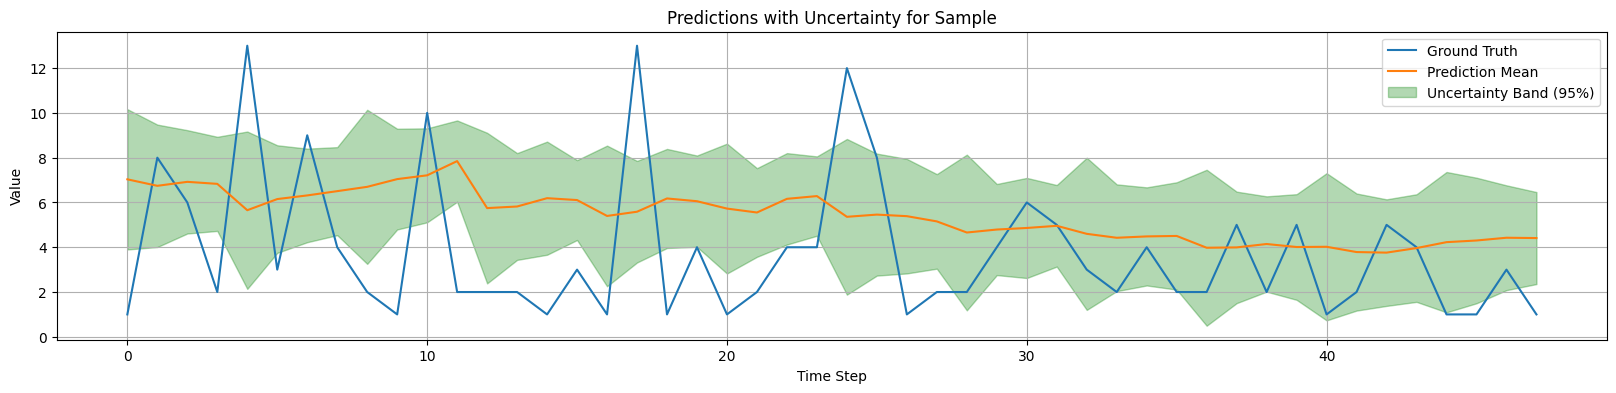

In [58]:
plot_sample_predictions()

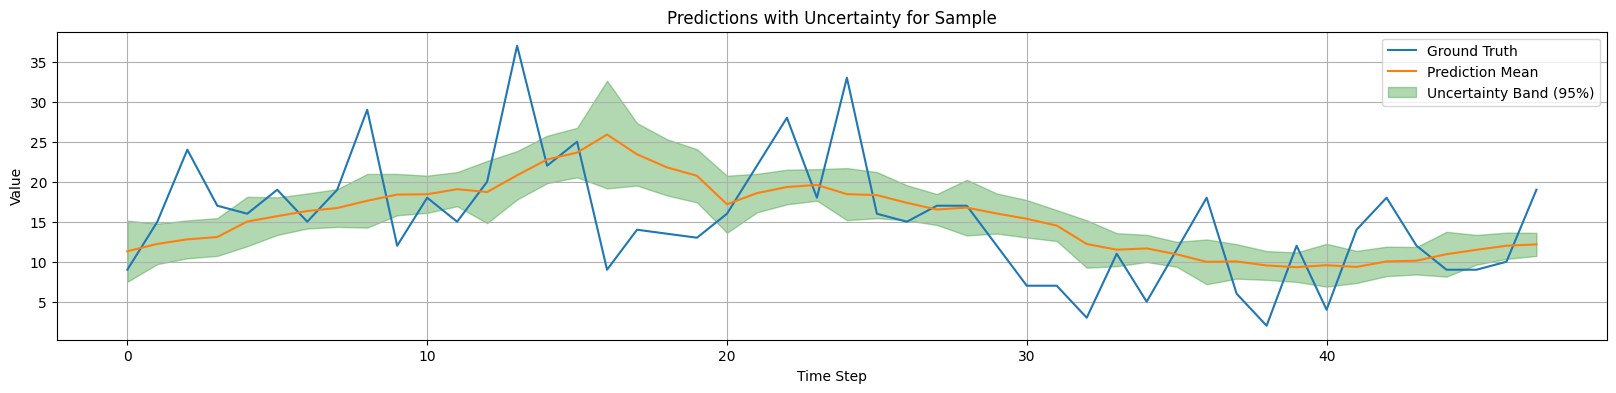

In [59]:
plot_sample_predictions()

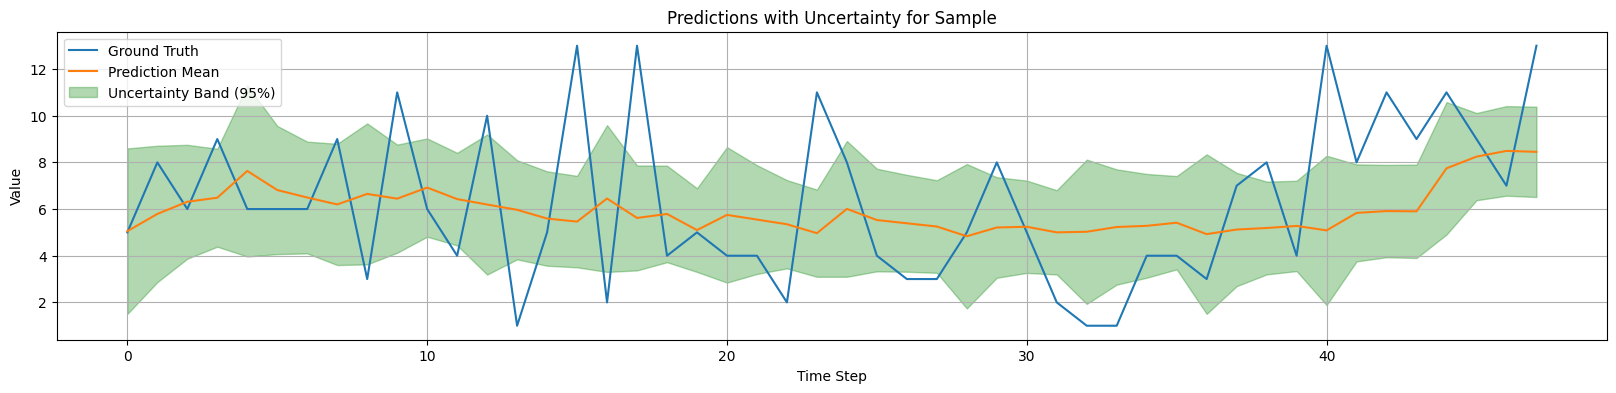

In [61]:
plot_sample_predictions()

## Embedding space : Are there any relevant clusters ? 

In [31]:
dfunik = df.drop_duplicates(IDCOL).reset_index(drop=True)
dfunik.head()

,SKU,normalizedCURRENT_LEVEL,inputSeq,outputSeq,targetWeeks
0,8700279387486518594,-0.385553,"[[4.0, -0.1205366803, -0.9927088741000001], [7...","[8.0, 23.0, 9.0, 4.0, 8.0, 4.0, 6.0, 25.0, 13....","[[0.35460488700000004, -0.9350162427], [0.4647..."
1,344215197461200907,-0.340142,"[[6.0, 0.9709418174000001, -0.2393156643], [5....","[4.0, 9.0, 15.0, 28.0, 10.0, 10.0, 11.0, 8.0, ...","[[0.9927088741000001, 0.1205366803], [0.970941..."
2,2116120427430972353,-0.390599,"[[1.0, 0.9709418174000001, 0.2393156643], [1.0...","[2.0, 1.0, 3.0, 3.0, 6.0, 1.0, 9.0, 2.0, 4.0, ...","[[0.6631226582, 0.7485107482000001], [0.568064..."
3,-4072187936043891304,-0.093910,"[[2.0, 0.1205366803, 0.9927088741000001], [5.0...","[3.0, 12.0, 6.0, 7.0, 5.0, 8.0, 8.0, 9.0, 11.0...","[[-0.35460488700000004, 0.9350162427], [-0.464..."
4,2585754207970204174,0.681115,"[[18.0, -0.7485107482000001, 0.6631226582], [1...","[6.0, 17.0, 31.0, 21.0, 32.0, 24.0, 18.0, 25.0...","[[-0.9709418174000001, 0.2393156643], [-0.9927..."


In [53]:
def embed_full_year(row):
    input_seq =torch.tensor(row[INPUT_SEQUENCE]).float().reshape(1,4,3)
    input_seq[:, :, 0] = min_max_normalize(input_seq[:, :, 0])

    output_seq =min_max_normalize(torch.tensor(row[OUTPUT_SEQUENCE]).float()).reshape(1,-1,1)
    target_weeks = torch.tensor(row[TARGET_WEEKS]).float().reshape(1,-1,2)
    output_seq = torch.cat([output_seq,target_weeks],dim=2)

    full_seq = torch.cat([input_seq,output_seq],dim=1) 
    scalar_input = torch.tensor(row[NORM_STATICOL]).float().reshape(1,1)
    encoder_outputs, hidden = model.encoder(full_seq,scalar_input)
    return encoder_outputs.detach().numpy().mean(1).flatten()

In [84]:
dfunik['embedding_vector']=dfunik.apply(lambda x : embed_full_year(x),axis=1)
dfunik[STATICOL] = dfunik[NORM_STATICOL]*STD_CURRENT_LEVELS+MEAN_CURRENT_LEVELS
dfunik['bucket_'+STATICOL] = pd.qcut(dfunik[STATICOL],np.linspace(0,1,6) , 
                           ['qt[0,.2]','qt[.2,.4]','qt[.4,.6]','qt[.6,.8]','qt[.8,1]'])

In [85]:
embeddings = np.stack(dfunik['embedding_vector'].values)
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(embeddings)
dfunik['TSNE_X'] = tsne_results[:, 0]
dfunik['TSNE_Y'] = tsne_results[:, 1]

In [87]:
fig = px.scatter(
    dfunik,
    x='TSNE_X',
    y='TSNE_Y',
    color='bucket_'+STATICOL,
    hover_data={IDCOL: True, STATICOL: True},
)

fig.update_layout(
    title='t-SNE Projection of Embedding Vectors',
    xaxis_title='TSNE_X',
    yaxis_title='TSNE_Y',width=1000,  # Set the width of the figure
    height=600  
)


fig.show()

/opt/homebrew/lib/python3.11/site-packages/plotly/express/_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/opt/homebrew/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



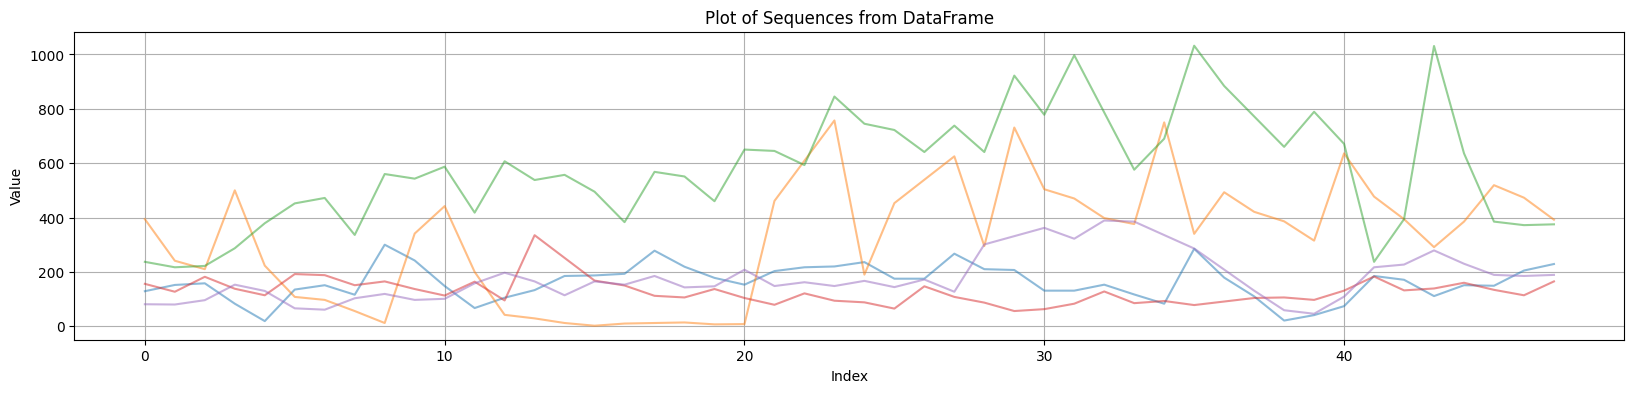

In [114]:
import matplotlib.pyplot as plt
def plot_group_samples(series_sequences):
    plt.figure(figsize=(20, 4))

    for seq in series_sequences:
        plt.plot(seq,alpha=.5)

    plt.title('Plot of Sequences from DataFrame')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
# CLUSTER 1 : ['TSNE_X']>82
plot_group_samples(dfunik[dfunik['TSNE_X']>82][OUTPUT_SEQUENCE].sample(5,random_state=10))

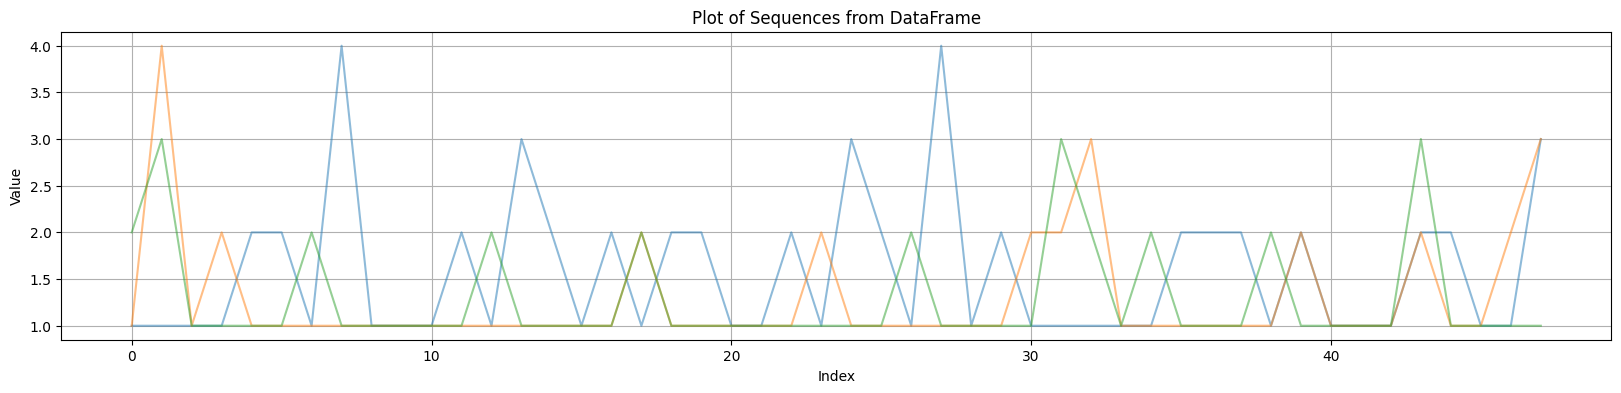

In [122]:
# CLUSTER 2 : -48<['TSNE_X']<-42 , -18<['TSNE_Y']<-13
plot_group_samples(dfunik[
    (dfunik['TSNE_X']>=-48) &  (dfunik['TSNE_X']<=-42) & (dfunik['TSNE_Y']>=-18) &  (dfunik['TSNE_Y']<=-13)
    ][OUTPUT_SEQUENCE].sample(3,random_state=0))

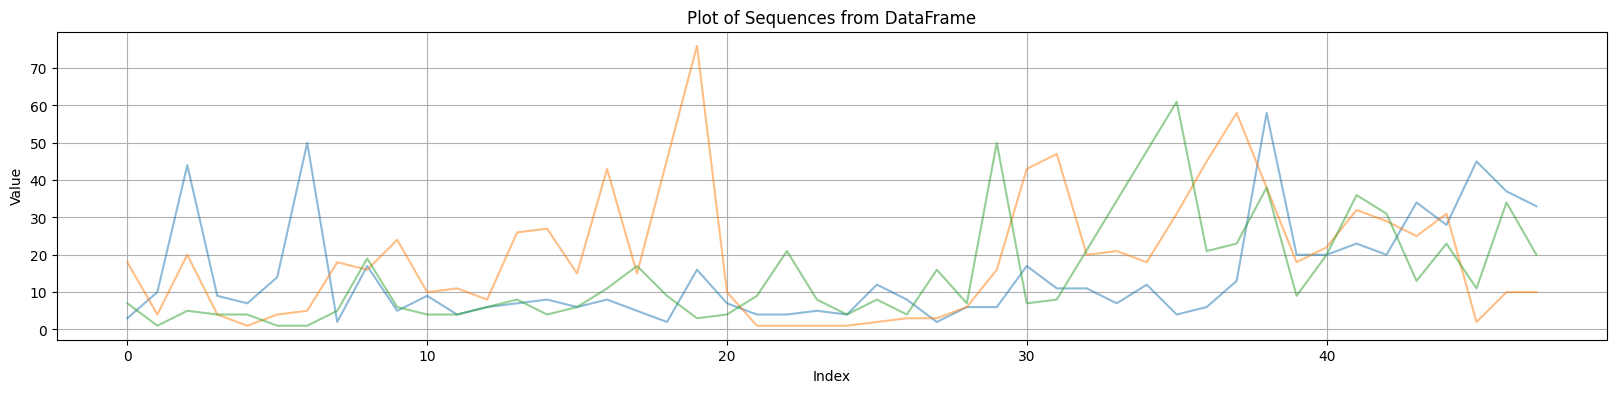

In [126]:
plot_group_samples(dfunik[
    (dfunik['TSNE_X']>=20) &  (dfunik['TSNE_X']<=28) & (dfunik['TSNE_Y']>=3) &  (dfunik['TSNE_Y']<=9)
    ][OUTPUT_SEQUENCE].sample(3,random_state=0))

- Encoder embedding space can be very useful when investiguating the model ,
- While we can observe some clusters indicating that the model has actually learnt some information , the embedding space still somewhat scarce which indicates that the model can still be improved 
- With more information about SKUs (categorical data) the embedding space would allow us to pick some very interesting when it comes to knowing why an SKU would behave a certain way , and would reinforce the profiling approach we discussed earlier 


## Attention :  What are the attention scores looking like 


In [3]:
def plot_sample_attention(random_state):
    sample = df.sample(random_state)
    display(sample.head(1))
    input_seq, input_scalar, target_weeks, output_seq = torch.tensor(sample[INPUT_SEQUENCE].values[0]),torch.tensor(sample[NORM_STATICOL].values[0]),torch.tensor(sample[TARGET_WEEKS].values[0]),torch.tensor(sample[OUTPUT_SEQUENCE].values[0])
    input_seq, input_scalar, target_weeks, output_seq=input_seq.float().reshape(1,4,3), input_scalar.float().reshape(1,1), target_weeks.float().reshape(1,-1,2), output_seq.float().reshape(1,-1)
    input_seq[:, :, 0] = min_max_normalize(input_seq[:, :, 0])
    output_seq = min_max_normalize(output_seq)
    predictions= predict_plot_attention(model, input_seq, input_scalar, target_weeks, targets=output_seq)
    return sample[IDCOL].values[0] , predictions 

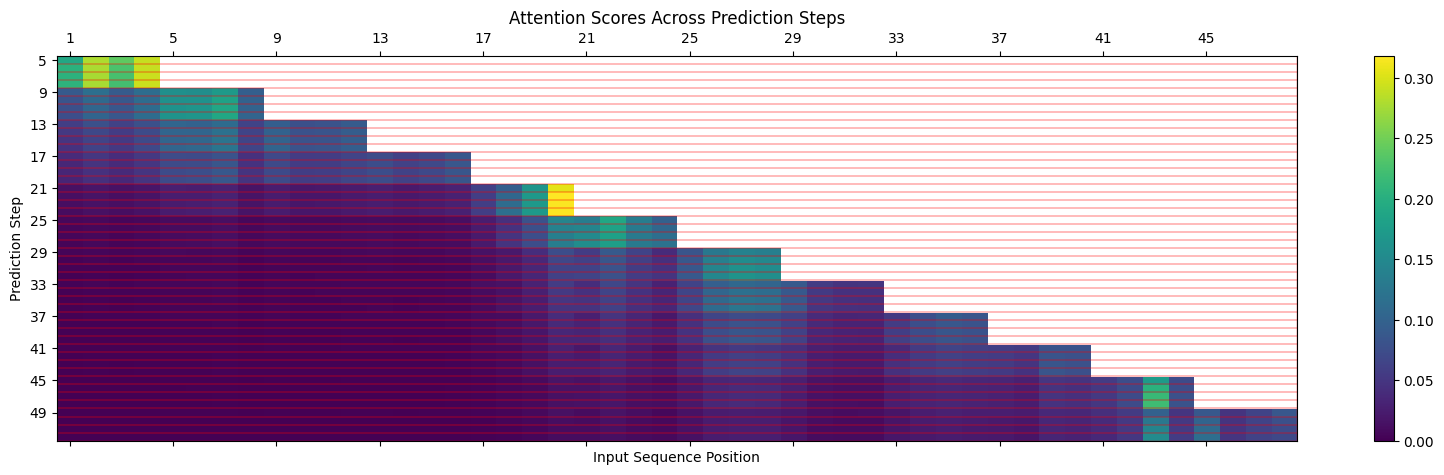

In [7]:
plot_sample_attention(1)

- For the first prediction (step=5 , look at first row highlighted in red ) , the model is focusing mostly on (step =4 ) and (step=2)
- It's interesting that the model is still giving importance to steps near 21 when predictiong 45 etc.. Looking at the actual values and dates would've provided more insights . These patterns would be typically related to seasonality , in fact this is one of the advantages of such approaches is allowing custom seasonalities per time series , and evey dynamic seasonalities , something difficult to incorporate in simpler models .
- The attention layer also can improve as early weeks importances (steps 1 ,2 ,3 ) vanishes when predicting further steps . It can  be due to the way attention was implemented (incremental updates to the encoder context)

,SKU,normalizedCURRENT_LEVEL,inputSeq,outputSeq,targetWeeks
54017,-1530954027219408091,-0.363352,"[[5.0, 0.2393156643, 0.9709418174000001], [15....","[5.0, 4.0, 7.0, 5.0, 13.0, 12.0, 5.0, 8.0, 10....","[[-0.2393156643, 0.9709418174000001], [-0.3546..."


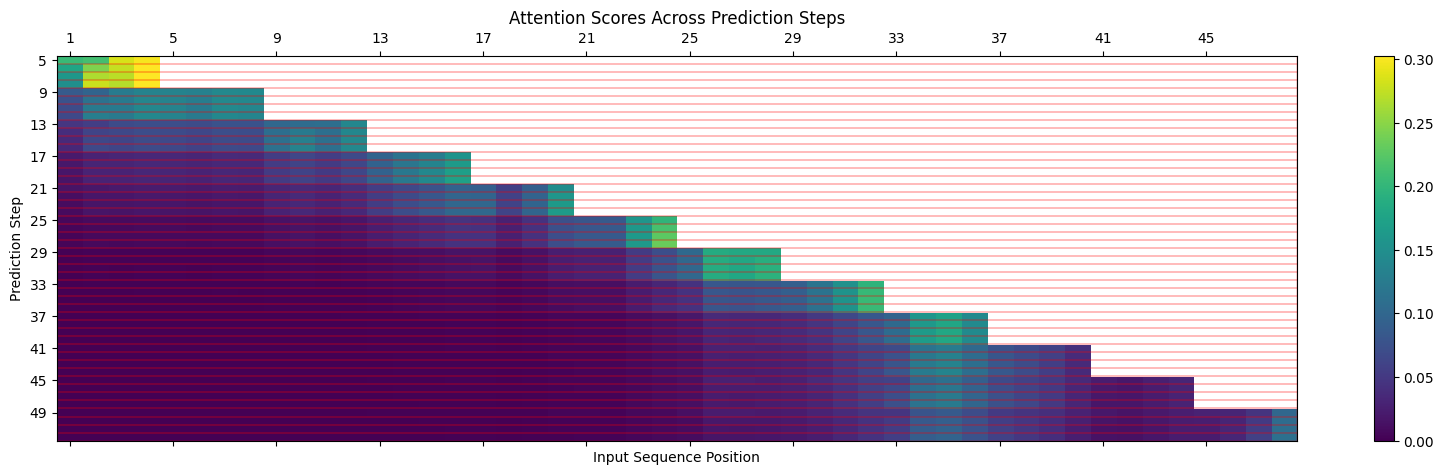

In [38]:
id_sku,_ = plot_sample_attention(100)

<Axes: >

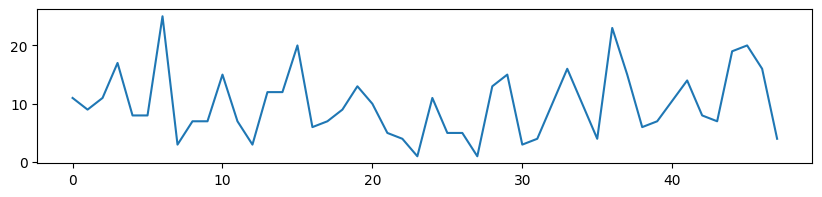

In [39]:
pd.Series(df[df.SKU==id_sku].outputSeq.values[0]).plot(figsize=(10,2))

- The sample above is interesting given that for the latest step we see the previous step activated , but we also see older weeks being activated too around steps 33 , 37 , which suggest that the model noticed some kind of seasonality , oppositely to previous samples


,SKU,normalizedCURRENT_LEVEL,inputSeq,outputSeq,targetWeeks
106385,-4462832846453208937,5.183931,"[[119.0, -0.6631226582, -0.7485107482000001], ...","[29.0, 45.0, 28.0, 17.5, 7.0, 34.0, 46.0, 23.0...","[[-0.2393156643, -0.9709418174000001], [-0.120..."


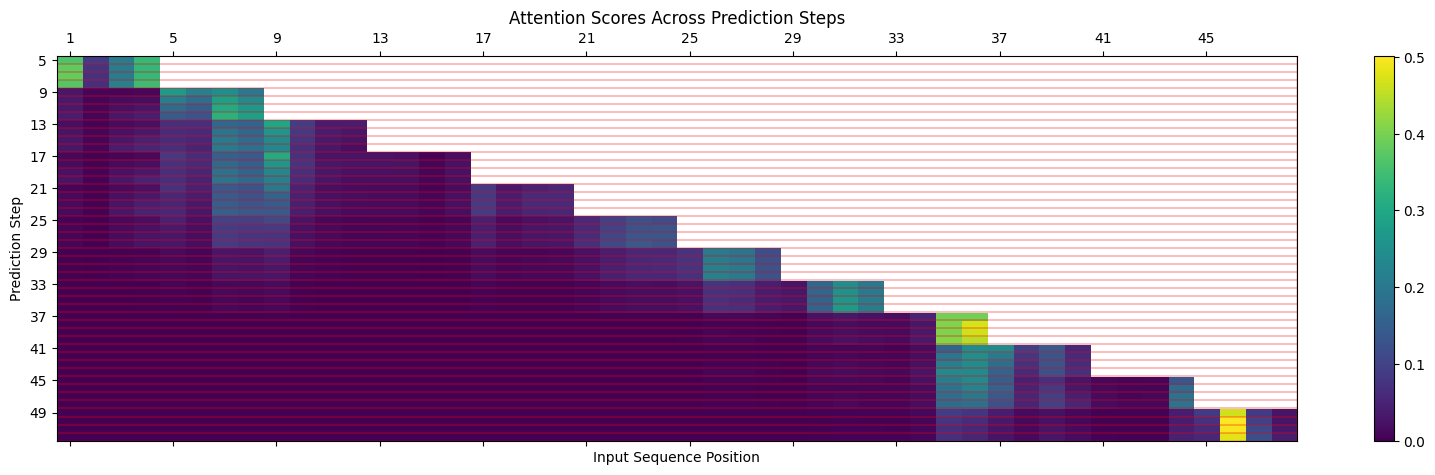

<Axes: >

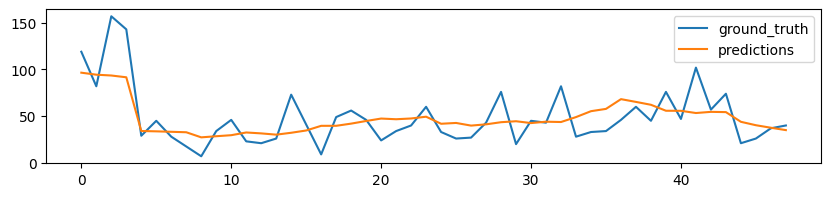

In [65]:
id_sku , predictions = plot_sample_attention(100)
pd.DataFrame(data={
    'ground_truth':df[df.SKU==id_sku].outputSeq.values[0],
    'predictions':predictions}).plot(figsize=(10,2))